In [1]:
import glob

%matplotlib inline
import mne
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns

# Figures inline and set visualization style
sns.set()
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fftpack import fft, fftfreq, ifft, irfft, rfft
from scipy.integrate import simps
from scipy.signal import butter, filtfilt, hilbert
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# First Step : Loading the data to be analyzed 

In [2]:
# read the excel files just in case 
patients_256 = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /Alle_patienten_256Hz.xlsx")
patients_250 = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /Alle_patienten_250Hz.xlsx")

### Here we change the names of some columns to work with them more easily later on 

In [3]:
patients_250 = patients_250.rename(columns = {"Burstsupressie (ja/nee)" : "BS",
                                                "Nummer" : "ID"})
patients_250 = patients_250.dropna(subset = ["ID"])
patients_250 = patients_250.astype({"ID" : int})
patients_250_ids = list(patients_250["ID"])

In [4]:
patients_256 = patients_256.rename(columns = {"Burstsupressie (ja/nee)" : "BS",
                                                "Nummer" : "ID"})
patients_256 = patients_256.dropna(subset = ["ID"])
patients_256 = patients_256.astype({"ID" : int})
patients_256_ids = list(patients_256["ID"])
#patients_df = pd.concat([patients_data, patients_data1])
#patients_df = patients_df.drop(["file code"], axis = 1)

### Read the signal data recorded from each patient 

In [5]:
patients = glob.glob("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /*.mat")
patient_files_250 = []
patient_files_256 = []

for i in range(0,len(patients)): 
    temp = patients[i].replace("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /patient_","")
    temp = int(temp.replace(".mat", ""))
    if temp in patients_250_ids:
        patient_files_250.append(patients[i])
    else:
        patient_files_256.append(patients[i])
    

### In the following code we define some information needed, such as channel names, trials and channel types to form the MNE signal objects, then define the channel locations and finally create the MNE Raw objects. 

In [6]:
# necessary information taken from the data in order to create MNE objects. 
channelLabels = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8",
                "A1", "T3", "C3", "Cz", "C4", "T4", "A2", "T5", 
                "P3", "Pz", "P4", 'T6', '01', '02', 'ECG']
trials = 1 
n_channels = 22
ch_types = ['eeg'] * (n_channels-3)
ch_types.append('misc')
ch_types.append('misc')
ch_types.append('ecg')

In [7]:
def define_montage(type):
    '''method that helps us define the channel locations '''

    # Form the 10-20 montage 'standard_1020'
    mont1020 = mne.channels.make_standard_montage(type)
    # Choose what channels you want to keep 
    # Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
    kept_channels = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8",
                "A1", "T3", "C3", "Cz", "C4", "T4", "A2", "T5", 
                "P3", "Pz", "P4", 'T6']
    ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
    mont1020_new = mont1020.copy()
    # Keep only the desired channels
    mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
    kept_channel_info = [mont1020.dig[x+3] for x in ind]
    # Keep the first three rows as they are the fiducial points information
    mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info
    
    #mont1020.plot()
    #mont1020_new.plot()
    
    return mont1020_new

In [8]:
def create_Raw_objects(patient_list,channelLabels,n_channels,sampling_frequency,phase,types,ids):
    evoked_arrays = {}
    for i in range(0,len(patient_list)): 
        patient = scipy.io.loadmat(patient_list[i])
        samples = patient[phase]["data"][0][0]
        
        info = mne.create_info(
        ch_names = channelLabels, 
        ch_types = types,
        sfreq = sampling_frequency)
        
        info.set_montage(define_montage('standard_1020'))
        evoked_array = mne.io.RawArray(samples, info)
        evoked_arrays.update({ids[i] : evoked_array })
    return evoked_arrays

In [9]:
eeg_InDia_250 = create_Raw_objects(patient_files_250, channelLabels, n_channels, 250,"EEG_INDIA",ch_types,patients_250_ids);
eeg_InDia_256 = create_Raw_objects(patient_files_256,channelLabels, n_channels, 256, "EEG_INDIA", ch_types,patients_256_ids);
#eeg_PreOK = create_MNE_objects(patients, channelLabels, n_channels, sampling_frequency, "EEG_PreOK",ch_types)
#eeg_Klem = create_MNE_objects(patients, channelLabels, n_channels, sampling_frequency, "EEG_Klem",ch_types)

Creating RawArray with float64 data, n_channels=22, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.004 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=391128
    Range : 0 ... 391127 =      0.000 ...  1564.508 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=169409
    Range : 0 ... 169408 =      0.000 ...   677.632 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=291251
    Range : 0 ... 291250 =      0.000 ...  1165.000 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=162501
    Range : 0 ... 162500 =      0.000 ...   650.000 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=152051
    Range : 0 ... 152050 =      0.000 ...   608.200 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=369993
    Range : 0 ... 369992 =      0.000 ...  1479.968 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=501
    Range : 0 ... 500 =     

In [10]:
def remove_zero_times(raw_array,patient_ids) :
    """
    remove the instances with zero sampling time from the patients list as they include no signal information. 
    return the id of the patients with no signal data, and the new eeg signal list 
    """
    res = raw_array.copy() 
    for i in raw_array: 
        if raw_array[i].n_times == 0 or raw_array[i].n_times == 1:
            del res[i]
            patient_ids.remove(i)
    
    return res,patient_ids

In [11]:
eeg_india_250, patients_250_ids= remove_zero_times(eeg_InDia_250,patients_250_ids)
eeg_india_256, patients_256_ids = remove_zero_times(eeg_InDia_256,patients_256_ids)


In [12]:
eeg_india = {}
eeg_india.update(eeg_india_250)
eeg_india.update(eeg_india_256)


Using matplotlib as 2D backend.


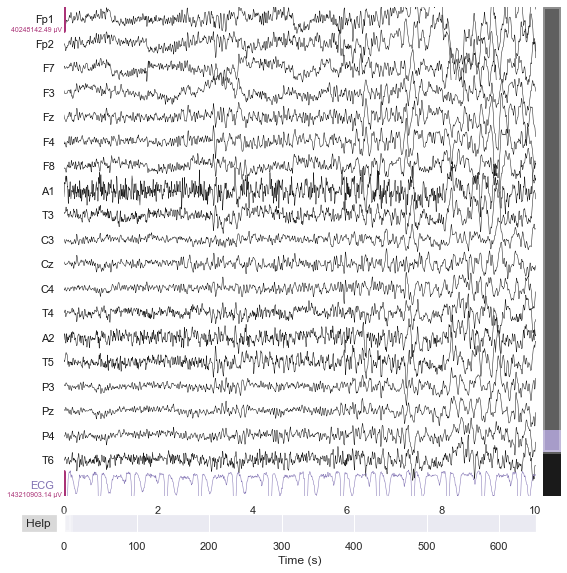

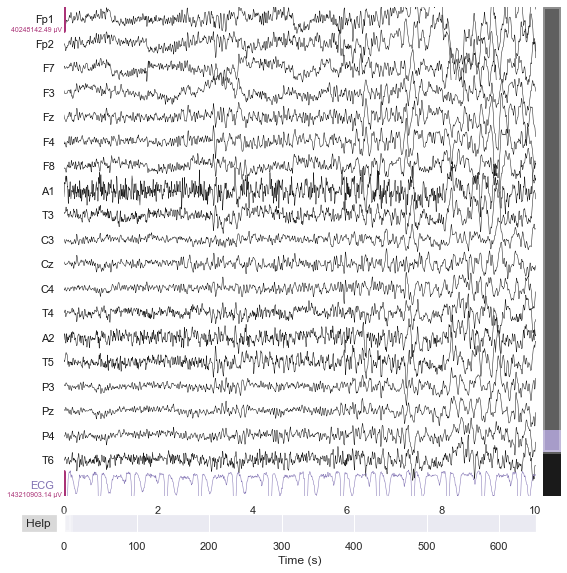

In [13]:
eeg_india[5].plot(scalings = "auto")

## Time Domain Features 

In [14]:
## extract time-domain features 

def calculate_mean(raw_array, patient_ids):
    mean_dict = {}
    for i in patient_ids: 

        col_mean = raw_array[i].get_data().mean(axis = 1)
        mean = col_mean.mean()

        mean_dict.update({i : mean})
    return mean_dict


def standard_deviation(raw_array, patient_ids): 
    std_dict = {}
    for i in patient_ids: 

        col_std = raw_array[i].get_data().std(axis = 1)
        std = col_std.std()

        std_dict.update({i : std})
    return std_dict

## Frequency Domain Transformation and Features

- Here the goal is to transform the signal data from each patient and extract the average power from each frequency band, to finally extract our features for the classification task. The signal data is transformed into the frequency domain using the Welch's method, then the average power is calculated by taking the area of interest, depending on the frequency band, under the curve. The same procedure is applied to each EEG channel. 
- As well as the mean power, the ratio between each band power, shannon entropy, which gives us information related to the periodicity of the signal is calculated. 

 -  delta (0.5–4 Hz)
  - theta (4–8 Hz)  
 -  alpha (8–12 Hz)
 -  beta (12–30 Hz)
 -  gamma (30–100 Hz)

In [15]:
def bandpower(data, sf, band, windowing = "hann", relative=False):
    """Compute the average power of the signal x in a specific frequency band.
        Absolute or relative band power.
    """
    from scipy.integrate import simps
    from scipy.signal import welch
    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, window=windowing)
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

def average_band_power(band, eeg_array,relative = False,windowing = "hann"):
    mean_bps = []
    for i in eeg_array: 
        bps = []
        for j in range(0,22): 
            bp = bandpower(eeg_array[i].get_data()[j],250,band, windowing, relative = relative)
            bps.append(bp) 
        mean  = np.mean(bps)
        mean_bps.append(mean)
    return mean_bps

In [16]:
eeg_india[16].compute_psd(window = "hann").plot(); 
eeg_india[16].compute_psd(window = "hamming").plot(); 
eeg_india[16].compute_psd(window = "blackman").plot(); 

Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


In [17]:
mean_power_delta = average_band_power([0.5,3],eeg_india)
mean_power_theta = average_band_power([4,7],eeg_india)
mean_power_alpha = average_band_power([8,11],eeg_india)
mean_power_beta = average_band_power([12,29],eeg_india)
mean_power_gamma = average_band_power([30,50],eeg_india)

In [18]:
mean_power_delta_hamming = average_band_power([0.5,3],eeg_india,windowing="hamming")
mean_power_theta_hamming = average_band_power([4,7],eeg_india,windowing="hamming")
mean_power_alpha_hamming = average_band_power([8,11],eeg_india,windowing="hamming")
mean_power_beta_hamming = average_band_power([12,29],eeg_india,windowing="hamming")
mean_power_gamma_hamming = average_band_power([30,50],eeg_india,windowing="hamming")

In [19]:
mean_power_delta_blackman = average_band_power([0.5,3],eeg_india,windowing="blackman")
mean_power_theta_blackman = average_band_power([4,7],eeg_india,windowing="blackman")
mean_power_alpha_blackman = average_band_power([8,11],eeg_india,windowing="blackman")
mean_power_beta_blackman = average_band_power([12,29],eeg_india,windowing="blackman")
mean_power_gamma_blackman = average_band_power([30,50],eeg_india,windowing="blackman")

In [20]:
# mean_rel_power_delta = average_band_power([0.5,3],eeg_india,relative = True)
# mean_rel_power_theta = average_band_power([4,7],eeg_india,relative = True)
# mean_rel_power_alpha = average_band_power([8,11],eeg_india,relative = True)
# mean_rel_power_beta = average_band_power([12,29],eeg_india,relative = True)
# mean_rel_power_gamma = average_band_power([30,50],eeg_india,relative = True)

In [21]:
# mean_rel_power_delta_hamming = average_band_power([0.5,3],eeg_india,relative = True, windowing="hamming")
# mean_rel_power_theta_hamming = average_band_power([4,7],eeg_india,relative = True,  windowing="hamming")
# mean_rel_power_alpha_hamming = average_band_power([8,11],eeg_india,relative = True, windowing="hamming")
# mean_rel_power_beta_hamming = average_band_power([12,29],eeg_india,relative = True, windowing="hamming")
# mean_rel_power_gamma_hamming = average_band_power([30,50],eeg_india,relative = True ,windowing="hamming")

In [22]:
# mean_rel_power_delta_blackman = average_band_power([0.5,3],eeg_india,relative = True, windowing="blackman")
# mean_rel_power_theta_blackman = average_band_power([4,7],eeg_india,relative = True,  windowing="blackman")
# mean_rel_power_alpha_blackman = average_band_power([8,11],eeg_india,relative = True, windowing="blackman")
# mean_rel_power_beta_blackman = average_band_power([12,29],eeg_india,relative = True, windowing="blackman")
# mean_rel_power_gamma_blackman = average_band_power([30,50],eeg_india,relative = True ,windowing="blackman")

In [23]:
def find_ratio(band1, band2): 
    ratio_array = []
    for i in range (0,len(band1)): 
        ratio = 1 / (band1[i] / band2[i])
        ratio_array.append(ratio)
    return ratio_array

In [24]:
delta_alpha = find_ratio(mean_power_delta,mean_power_alpha)
delta_beta = find_ratio(mean_power_delta,mean_power_beta)
delta_theta = find_ratio(mean_power_delta,mean_power_theta)
delta_gamma = find_ratio(mean_power_delta,mean_power_gamma)

alpha_beta = find_ratio(mean_power_alpha,mean_power_beta)
alpha_theta = find_ratio(mean_power_alpha,mean_power_theta)
alpha_gamma = find_ratio(mean_power_alpha, mean_power_gamma)

beta_theta = find_ratio(mean_power_beta,mean_power_theta)
beta_gamma = find_ratio(mean_power_beta,mean_power_gamma)

theta_gamma = find_ratio(mean_power_theta,mean_power_gamma)


In [25]:
delta_alpha_hamming = find_ratio(mean_power_delta_hamming,mean_power_alpha_hamming)
delta_beta_hamming = find_ratio(mean_power_delta_hamming,mean_power_beta_hamming)
delta_theta_hamming = find_ratio(mean_power_delta_hamming,mean_power_theta_hamming)
delta_gamma_hamming = find_ratio(mean_power_delta_hamming,mean_power_gamma_hamming)

alpha_beta_hamming = find_ratio(mean_power_alpha_hamming,mean_power_beta_hamming)
alpha_theta_hamming = find_ratio(mean_power_alpha_hamming,mean_power_theta_hamming)
alpha_gamma_hamming = find_ratio(mean_power_alpha_hamming, mean_power_gamma_hamming)

beta_theta_hamming = find_ratio(mean_power_beta_hamming,mean_power_theta_hamming)
beta_gamma_hamming = find_ratio(mean_power_beta_hamming,mean_power_gamma_hamming)

theta_gamma_hamming = find_ratio(mean_power_theta_hamming,mean_power_gamma_hamming)

In [26]:
delta_alpha_blackman = find_ratio(mean_power_delta_blackman,mean_power_alpha_blackman)
delta_beta_blackman = find_ratio(mean_power_delta_blackman,mean_power_beta_blackman)
delta_theta_blackman = find_ratio(mean_power_delta_blackman,mean_power_theta_blackman)
delta_gamma_blackman = find_ratio(mean_power_delta_blackman,mean_power_gamma_blackman)

alpha_beta_blackman = find_ratio(mean_power_alpha_blackman,mean_power_beta_blackman)
alpha_theta_blackman = find_ratio(mean_power_alpha_blackman,mean_power_theta_blackman)
alpha_gamma_blackman = find_ratio(mean_power_alpha_blackman, mean_power_gamma_blackman)

beta_theta_blackman = find_ratio(mean_power_beta_blackman,mean_power_theta_blackman)
beta_gamma_blackman = find_ratio(mean_power_beta_blackman,mean_power_gamma_blackman)

theta_gamma_blackman = find_ratio(mean_power_theta_blackman,mean_power_gamma_blackman)

In [27]:
def calc_shannon_entropy(data_set):
    entropies = []
    for i in data_set: 
        probability = np.square(data_set[i].get_data())
        shannon_entropy = -np.nansum(probability * np.log2(probability))
        entropies.append(round(shannon_entropy, 3))
    return entropies

In [28]:
shannon_entropy = calc_shannon_entropy(eeg_india)

In [29]:
ids = patients_250_ids+ patients_256_ids
power_df_hann = pd.DataFrame({"ID" : ids, 
                        "mean_alpha" : mean_power_alpha,
                        "mean_beta" : mean_power_beta, 
                        "mean_delta" : mean_power_delta, 
                        "mean_theta" : mean_power_theta, 
                        "mean_gamma" : mean_power_gamma,
                        "delta_alpha" : delta_alpha,
                        "delta_beta" : delta_beta,
                        "delta_theta" : delta_theta, 
                        "delta_gamma" : delta_gamma, 
                        "alpha_beta" : alpha_beta, 
                        "alpha_theta" : alpha_theta, 
                        "alpha_gamma": alpha_gamma, 
                        "beta_theta" : beta_theta,
                        "beta_gamma" : beta_gamma,
                        "theta_gamma" : theta_gamma,
                        "shannon_entropy" : shannon_entropy})



In [30]:
power_df_hamming = pd.DataFrame({"ID" : ids, 
                        "mean_alpha" : mean_power_alpha_hamming,
                        "mean_beta" : mean_power_beta_hamming, 
                        "mean_delta" : mean_power_delta_hamming, 
                        "mean_theta" : mean_power_theta_hamming, 
                        "mean_gamma" : mean_power_gamma_hamming,
                        "delta_alpha" : delta_alpha_hamming,
                        "delta_beta" : delta_beta_hamming,
                        "delta_theta" : delta_theta_hamming, 
                        "delta_gamma" : delta_gamma_hamming, 
                        "alpha_beta" : alpha_beta_hamming, 
                        "alpha_theta" : alpha_theta_hamming, 
                        "alpha_gamma": alpha_gamma_hamming, 
                        "beta_theta" : beta_theta_hamming,
                        "beta_gamma" : beta_gamma_hamming,
                        "theta_gamma" : theta_gamma_hamming,
                        "shannon_entropy" : shannon_entropy})

In [31]:
power_df_blackman = pd.DataFrame({"ID" : ids, 
                        "mean_alpha" : mean_power_alpha_blackman,
                        "mean_beta" : mean_power_beta_blackman, 
                        "mean_delta" : mean_power_delta_blackman, 
                        "mean_theta" : mean_power_theta_blackman, 
                        "mean_gamma" : mean_power_gamma_blackman,
                        "delta_alpha" : delta_alpha_blackman,
                        "delta_beta" : delta_beta_blackman,
                        "delta_theta" : delta_theta_blackman, 
                        "delta_gamma" : delta_gamma_blackman, 
                        "alpha_beta" : alpha_beta_blackman, 
                        "alpha_theta" : alpha_theta_blackman, 
                        "alpha_gamma": alpha_gamma_blackman, 
                        "beta_theta" : beta_theta_blackman,
                        "beta_gamma" : beta_gamma_blackman,
                        "theta_gamma" : theta_gamma_blackman,
                        "shannon_entropy" : shannon_entropy})

In [32]:
def plot_spectrum_methods(data, sf, window_sec, band=None, dB=False):

    import matplotlib.pyplot as plt
    from mne.time_frequency import psd_array_multitaper
    from scipy.signal import periodogram, welch
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs, psd = periodogram(data, sf)
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    psd_mt, freqs_mt = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd = 10 * np.log10(psd)
        psd_welch = 10 * np.log10(psd_welch)
        psd_mt = 10 * np.log10(psd_mt)
        sharey = True

    # Start plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax2.stem(freqs, psd, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax1.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax3.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax2.plot(freqs, psd, lw=lw, color=lc)
    ax1.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    ax3.plot(freqs_mt, psd_mt, lw=lw, color=lc)
    # Labels and axes
    ax1.set_xlabel('Frequency (Hz)')
    if not dB:
        ax1.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax1.set_ylabel('Decibels (dB / Hz)')
    ax2.set_title('Periodogram')
    ax1.set_title('Mean-power Alpha Band')
    ax3.set_title('Multitaper')
    if band is not None:
        ax1.set_xlim(band)
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)
    sns.despine()


In [33]:
plot_spectrum_methods(eeg_india[16].get_data()[2], 250, 4, band=[4,7], dB=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


NOTE: plot_psd_topo() is a legacy function. New code should use .compute_psd().plot_topo().
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


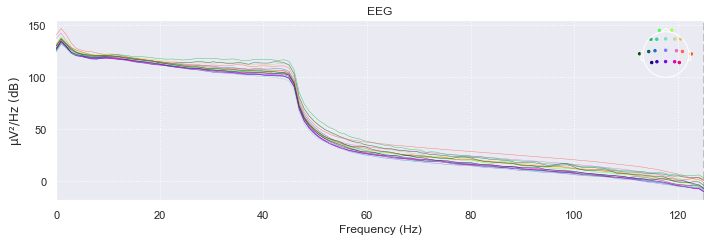

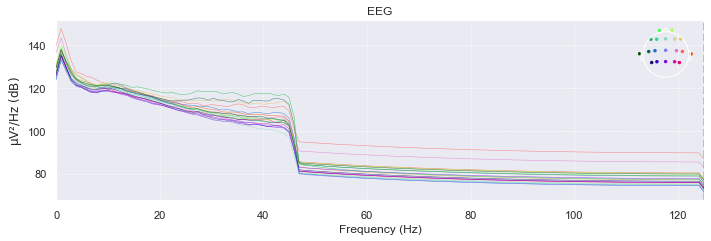

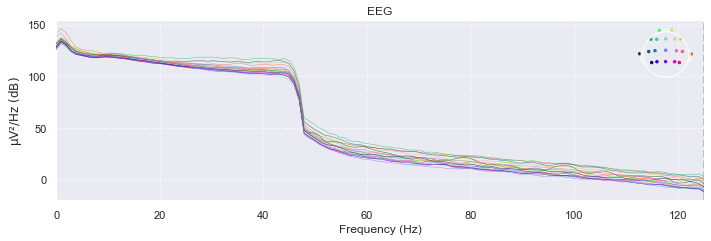

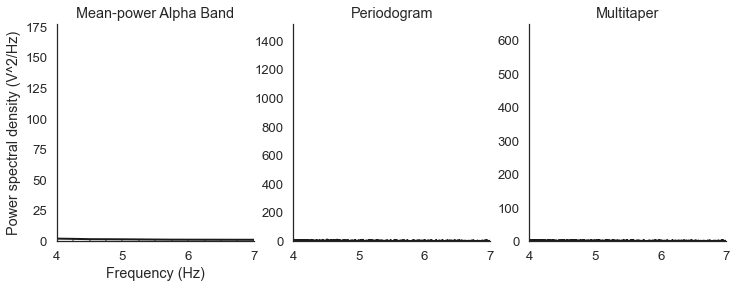

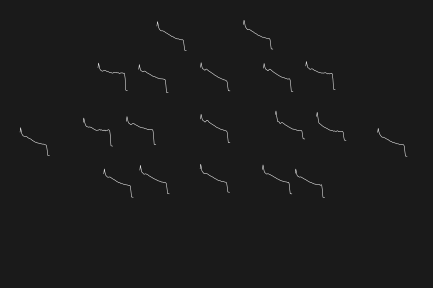

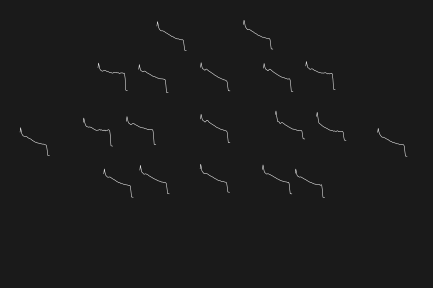

In [34]:
eeg_india[16].plot_psd_topo(fmax = 50)


Effective window size : 1.024 (s)


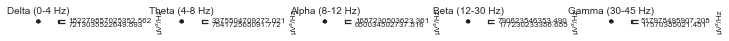

In [35]:
eeg_india[16].compute_psd().plot_topomap();

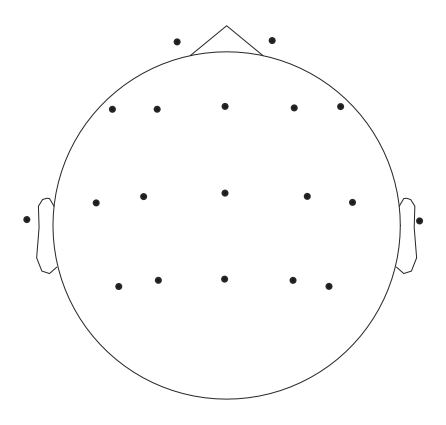

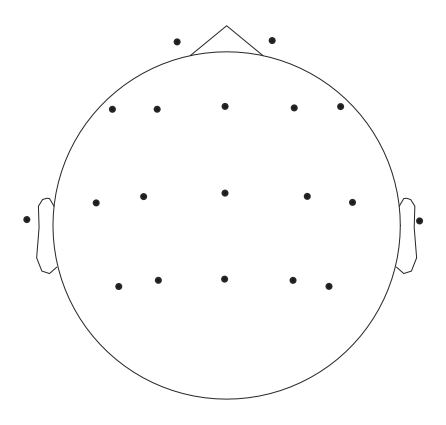

In [36]:
eeg_india[16].plot_sensors(ch_type = "eeg")

# EDA and Feature Selection 

In [37]:
power_df = [power_df_hann,power_df_blackman,power_df_hamming]
patients_df = patients_250.append(patients_256,ignore_index=True)
patients_df = patients_df[patients_df["ID"].isin(ids)]

additional = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /additional_data.xlsx")
additional = additional.rename(columns={"Subject_no" : "ID"})
additional= additional[additional["ID"].isin(ids)]

temp = []
for i in power_df: 
       patients_df_1 = pd.merge(patients_df,i, on = "ID")
       patients_df_1.drop(["Tijdstip ogen dicht", "Tijdstip ogen open", "tijdstip tweede ogen dicht", "tijdstip tweede ogen open", 
                   "tijdstip derde ogen dicht","tijdstip derde ogen open", "Tijdstip start op OK","Tijdstip start inleiding",'Tijdstip start diathermie', 'Tijdstip start klem', 'Duur klem',
       'Tijdstip einde OK', 'file code','opm'], inplace=True, axis=1)
       patients_df_1["BS"] = patients_df_1["BS"].map({'ja' : 1, 'nee' : 0})
       final_df = pd.merge(patients_df_1,additional, on = "ID")
       temp.append(final_df)

final_df = temp[0].append(temp[1])
final_df = final_df.append(temp[2])
final_df = final_df.reset_index()
final_df

,index,ID,BS,Age at OR,mean_alpha,mean_beta,mean_delta,mean_theta,mean_gamma,delta_alpha,...,RRdiastolic3minutesafterclampingmmHg,RRdiastolicrightafterclampreleasemmHg,RRdiastolic1minuteafterclampreleasemmHg,RRdiastolic3minutesafterclampreleasemmHg,RRdiastolicendofORmmHg,meanmicroembolismduringOR≈,summicroembolismduringOR,meanmicroembolismafterOR≈,summicroembolismafterendofOR,interventionbecauseofMES
0,0,2,NaN,78.168378,484.122333,1206.451804,7819.567730,1033.705815,339.323865,0.061912,...,81.0,77.0,78.0,78.0,0.0,NaN,22,0,0,0.0
1,1,3,NaN,69.295003,52.121272,114.263692,188.153155,63.065716,7.388622,0.277015,...,67.0,42.0,39.0,39.0,44.0,"0,04/ min",3,"0,07/ min",4,0.0
2,2,4,NaN,71.107461,95.553029,198.835001,1842.913089,266.041115,17.694502,0.051849,...,74.0,79.0,73.0,67.0,0.0,NaN,7,0,0,0.0
3,3,5,NaN,74.759754,83.644352,134.293793,407.933552,220.821627,8.890327,0.205044,...,0.0,65.0,62.0,60.0,55.0,0,0,0,0,0.0
4,4,6,NaN,78.954141,537.857676,990.251669,5163.701573,1456.762738,204.630782,0.104161,...,103.0,0.0,0.0,85.0,100.0,0,0,#,#,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,243,373,0.0,79.362081,114.842469,260.034243,753.856853,220.581797,23.504143,0.152340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
740,244,375,1.0,69.804244,45.887716,205.232543,383.693001,66.497328,23.887827,0.119595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,245,376,0.0,75.707050,9153.421451,87347.962565,11291.556149,10490.181156,66419.497155,0.810643,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742,246,377,1.0,69.253936,38.161854,63.883841,289.678930,98.224684,4.056301,0.131738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Selection  : 
 - The first step is to handle the columns with missing values; in this case I removed the columns that have a missing value ratio of 20% 
 - Second is to apply a high correlation filter so that we get rid of the columns that are redundant 

In [38]:
def remove_uninformative_features(df): 
    uninformative_features = []
    for i in df.columns: 
        if (i != "BS") & (df[i].isna().sum()/df.shape[0] * 100 >= 15): 
            uninformative_features.append(i)
    new_df = df.drop(uninformative_features, axis = 1)
    return new_df

In [39]:
def low_variance_filter(df): 
    uninformative_features = []
    for i in df.columns: 
        if (i != "BS") & (df[i].var() <= 1.1): 
            uninformative_features.append(i)
    new_df = df.drop(uninformative_features, axis = 1)
    return new_df

In [40]:
final_df = final_df.drop(["Dosage_etomidate","Length", "Weight","latencyofclampingtoEEGchangesminutes",
             "Age at OR","Hypertension_tom", "kindofcomplication1","Antihypertensiva_recovery" ],axis = 1)
final_df = remove_uninformative_features(final_df)


In [41]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):

#     print(corrFilter(final_df,0.7))

In [42]:
final_df = final_df.drop(["ID",'shunting', 'shunt_indication', 'complication',
            'Deathin90days', 'latency',
       'vertebral_artery_stenosis'],axis =1)
final_df.columns

Index(['index', 'BS', 'mean_alpha', 'mean_beta', 'mean_delta', 'mean_theta',
       'mean_gamma', 'delta_alpha', 'delta_beta', 'delta_theta', 'delta_gamma',
       'alpha_beta', 'alpha_theta', 'alpha_gamma', 'beta_theta', 'beta_gamma',
       'theta_gamma', 'shannon_entropy', 'Gender', 'Age_OR', 'Smoking',
       'hypertension', 'diabetes', 'obesity', 'dyslipidaemia',
       'coronar_artery_disease', 'PAD', 'symptomatic_stenosis',
       'Kind_of_symptomatic_TIAstroke', 'localisation_of_operation',
       'type_of_operation', 'contralateral_stenosis',
       'degree_of_contralateral_stenosis_NASCET', 'clamping_time_min',
       'EEGchanges', 'TIA', 'Stroke', 'MI', 'Nervedamage',
       'postopbleedingIntracranicalHemorrhage', 'preop_aspirin',
       'preop_clopidogrel', 'preop_statins', 'preop_dipyridamol',
       'preop_vit_K_antagonit', 'preop_antihypertensives', 'preop_DOAC_NOAC',
       'preop_other_anticoagualation', 'intraoperative_protamine',
       'postop_antihypertensives', '

In [43]:
annotated_df  = final_df[final_df["BS"].notna()]
not_annotated_df = final_df[final_df["BS"].isna()]
sns.countplot(x='BS', data=annotated_df)

<AxesSubplot:xlabel='BS', ylabel='count'>

In [44]:
sns.countplot(x = "Gender",data=annotated_df,hue = "BS")

<AxesSubplot:xlabel='Gender', ylabel='count'>

In [45]:
sns.violinplot(x = "mean_delta",data=annotated_df,hue = "BS")

<AxesSubplot:xlabel='mean_delta', ylabel='count'>

In [46]:
sns.histplot(x = "Age_OR", data=annotated_df,hue="BS")

<AxesSubplot:xlabel='mean_delta', ylabel='count'>

In [47]:
## fill in the missing values 
annotated_df["type_of_operation"].fillna(annotated_df["type_of_operation"].mode()[0], inplace=True)
annotated_df["clamping_time_min"].fillna(annotated_df["clamping_time_min"].mean(), inplace= True)


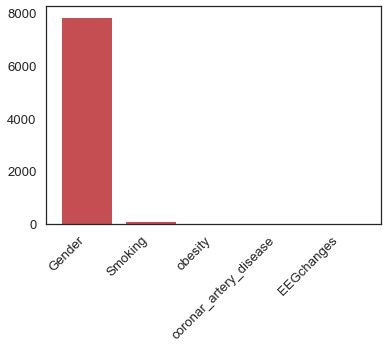

In [141]:
from sklearn.feature_selection import SelectKBest,chi2,f_classif
X = annotated_df[['Gender', 'Smoking', 'hypertension',
       'diabetes', 'obesity', 'dyslipidaemia', 'coronar_artery_disease', 'PAD',
       'symptomatic_stenosis','EEGchanges','TCD']]
y = annotated_df["BS"]
X = X.astype(int)
chi2_selector = SelectKBest(chi2, k = 5)
chi2_selector.fit(X,y)
chi2_scores = pd.DataFrame(list(zip(X.columns, chi2_selector.scores_, chi2_selector.pvalues_)), columns=['ftr', 'score', 'pval'])
chi2_scores

kbest = np.asarray(X.columns)[chi2_selector.get_support()]
kbest
indices = np.argsort(chi2_selector.scores_)[::-1]
plt.figure()
plt.bar(kbest, chi2_selector.scores_[indices[range(5)]], color='r', align='center')
plt.xticks(rotation=45, ha='right')
plt.show()

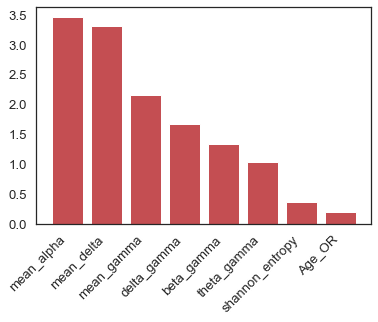

In [74]:
anova_selector = SelectKBest(score_func=f_classif,k = 8)
X = annotated_df[['mean_alpha', 'mean_delta', 'mean_theta',
       'mean_gamma', 'delta_alpha',
       'delta_beta', 'delta_theta', 'delta_gamma', 'beta_theta', 'beta_gamma', 'theta_gamma',
       'shannon_entropy','Age_OR']]
y = annotated_df["BS"]
anova_selector.fit(X,y)
anova_scores = pd.DataFrame(list(zip(X.columns, anova_selector.scores_, anova_selector.pvalues_)), columns=['ftr', 'score', 'pval'])
anova_scores

kbest = np.asarray(X.columns)[anova_selector.get_support()]
kbest

indices = np.argsort(anova_selector.scores_)[::-1]
plt.figure()
plt.bar(kbest, anova_selector.scores_[indices[range(8)]], color='r', align='center')
plt.xticks(rotation=45, ha='right')
plt.show()

In [119]:
selected_annotated_df = annotated_df[['mean_delta','mean_alpha','mean_theta', 'mean_gamma', 'delta_gamma',
'theta_gamma',"shannon_entropy",'Age_OR','Gender',"BS"]]
#selected_annotated_df['EEGchanges'] = selected_annotated_df["EEGchanges"].replace([999],selected_annotated_df["EEGchanges"].mode())
selected_annotated_df = selected_annotated_df.reset_index()
selected_annotated_df = selected_annotated_df.drop("index", axis=1)
selected_annotated_df

,mean_delta,mean_alpha,mean_theta,mean_gamma,delta_gamma,theta_gamma,shannon_entropy,Age_OR,Gender,BS
0,6966.698541,76.911589,473.715629,8.500036,0.001220,0.017943,-6.035306e+10,76.889802,0,1.0
1,40.856852,8.049408,6.799223,0.448450,0.010976,0.065956,-1.633001e+09,74.047912,0,0.0
2,4529.458745,322.851751,913.389779,206.001686,0.045480,0.225535,-1.750730e+12,59.838467,1,0.0
3,2699.343738,153.387429,359.869927,33.997802,0.012595,0.094472,-1.609249e+12,57.924709,0,1.0
4,982.926731,145.188979,376.017651,45.005250,0.045787,0.119689,-1.040368e+12,88.131417,1,0.0
...,...,...,...,...,...,...,...,...,...,...
400,753.856853,114.842469,220.581797,23.504143,0.031179,0.106555,-4.612504e+11,79.362081,1,0.0
401,383.693001,45.887716,66.497328,23.887827,0.062258,0.359230,-4.185492e+10,69.804244,0,1.0
402,11291.556149,9153.421451,10490.181156,66419.497155,5.882227,6.331587,-4.427380e+12,75.707050,0,0.0
403,289.678930,38.161854,98.224684,4.056301,0.014003,0.041296,-9.307036e+09,69.253936,0,1.0


## Classification 

TODO : Implement Stratified K fold CV 
 - scores to consider : precision, recall, f1, AUC 

 - choose the best K for CV and threshold for f1 score. 

In [120]:
from numpy import *
from sklearn import metrics, model_selection, tree, preprocessing, svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.metrics import precision_score,recall_score,roc_auc_score,f1_score,confusion_matrix,roc_curve,auc
from sklearn.model_selection import StratifiedKFold,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [121]:
feature_cols = selected_annotated_df.drop("BS", axis=1)
X = feature_cols
y = selected_annotated_df.BS


### Stratified K-Fold Cross Validation 

In [122]:
print("Class Ratio : ", sum(selected_annotated_df["BS"]) / len(selected_annotated_df["BS"]))
skf = StratifiedKFold(n_splits= 5)
target = selected_annotated_df.loc[:,"BS"]

fold = 1
for train_index,test_index in skf.split(selected_annotated_df,target):
    train = selected_annotated_df.loc[train_index,:]
    test = selected_annotated_df.loc[test_index,:]
    print("Fold",str(fold),"Class Ratio : ", sum(test["BS"]) / len(test["BS"]))
    fold +=1


Class Ratio :  0.2740740740740741
Fold 1 Class Ratio :  0.2839506172839506
Fold 2 Class Ratio :  0.2716049382716049
Fold 3 Class Ratio :  0.2716049382716049
Fold 4 Class Ratio :  0.2716049382716049
Fold 5 Class Ratio :  0.2716049382716049


In [123]:
def train_model(train,test,fold_no,model,X = None):
    if(X is None):
         X = selected_annotated_df.drop("BS", axis=1).columns
    y = ["BS"]

    X_train = train[X]
    y_train = train[y]

    X_test = test[X]
    y_test = test[y]

    model.fit(X_train,y_train)
    predictions = model.predict(X_test)

    prec = precision_score(y_test,predictions)
    recall = recall_score(y_test,predictions)
    f1 = f1_score(y_test,predictions)
    auc_score = roc_auc_score(y_test,predictions)
    fpr, tpr, threshold = metrics.roc_curve(y_test,predictions)
    roc_auc = metrics.auc(fpr,tpr)

    # plt.title('Receiver Operating Characteristic')
    # plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    # plt.legend(loc = 'lower right')
    # plt.plot([0, 1], [0, 1],'r--')
    # plt.xlim([0, 1])
    # plt.ylim([0, 1])
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.show()





    

    return prec,recall,f1,auc_score,fpr,tpr,roc_auc
   # print("Fold", str(fold_no), "Precision: ",precision_score(y_test,predictions)
    #    ,"Recall : ", recall_score(y_test,predictions), "F1-score : ", f1_score(y_test,predictions))


In [124]:
def validate(model,X = None):
    fold_no =1
    prec = []
    recall = []
    f1 = []
    auc = []
    fprs =[]
    tprs = []
    for train_index,test_index in skf.split(selected_annotated_df,target):
        train = selected_annotated_df.loc[train_index,:]
        test = selected_annotated_df.loc[test_index,:]
        p,r,f,a,fpr,tpr,roc_auc = train_model(train,test,fold_no,model,X)
        prec.append(p)
        recall.append(r)
        f1.append(f)
        auc.append(a)
        fprs.append(fpr)
        tprs.append(tpr)
        fold_no+=1
    print("Model : ", str(model), "Precision: ", sum(prec) / len(prec),"Recall : ", sum(recall)/len(recall), "F1-score : ", sum(f1)/len(f1),"AUC : ",sum(auc)/len(auc))



In [136]:
decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5)
random_forest_clf = RandomForestClassifier(max_depth = 7, n_estimators=250)
xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state = 42)
log_res = LogisticRegression()
#support_vector = svm.SVC(kernel="poly")

In [137]:
validate(decision_tree)

validate(random_forest_clf)

validate(xgb_classifier)

validate(log_res)

#validate(svm)

Model :  DecisionTreeClassifier(criterion='entropy', max_depth=5) Precision:  0.9532467532467532 Recall :  0.29841897233201575 F1-score :  0.4454960110132524 AUC :  0.6458196556575333
Model :  RandomForestClassifier(max_depth=7, n_estimators=250) Precision:  1.0 Recall :  0.8023715415019762 F1-score :  0.8891527599486521 AUC :  0.9011857707509883
Model :  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
            

In [114]:
rfc_parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
}

cv = GridSearchCV(random_forest_clf,rfc_parameters,cv=5)
cv.fit(X,y.ravel())

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

display(cv)

Best parameters are: {'max_depth': 16, 'n_estimators': 50}


0.736 + or -0.013 for the {'max_depth': 2, 'n_estimators': 5}
0.738 + or -0.016 for the {'max_depth': 2, 'n_estimators': 10}
0.726 + or -0.005 for the {'max_depth': 2, 'n_estimators': 50}
0.728 + or -0.008 for the {'max_depth': 2, 'n_estimators': 100}
0.728 + or -0.008 for the {'max_depth': 2, 'n_estimators': 250}
0.788 + or -0.05 for the {'max_depth': 4, 'n_estimators': 5}
0.81 + or -0.023 for the {'max_depth': 4, 'n_estimators': 10}
0.817 + or -0.023 for the {'max_depth': 4, 'n_estimators': 50}
0.817 + or -0.029 for the {'max_depth': 4, 'n_estimators': 100}
0.815 + or -0.037 for the {'max_depth': 4, 'n_estimators': 250}
0.938 + or -0.037 for the {'max_depth': 8, 'n_estimators': 5}
0.96 + or -0.014 for the {'max_depth': 8, 'n_estimators': 10}
0.985 + or -0.014 for the {'max_depth': 8, 'n_estimators': 50}
0.988 + or -0.008 for the {'max_depth': 8, 'n_estimators': 100}
0.988 + or -0.016 for the {'max_depth': 8, 'n_estimators':

No handles with labels found to put in legend.


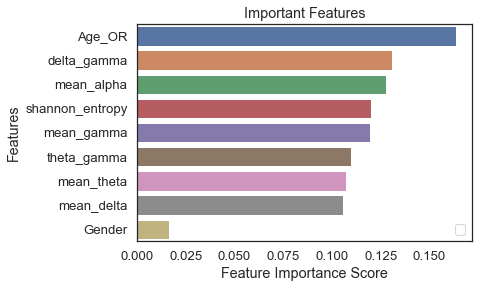

In [127]:
feature_imp = pd.Series(random_forest_clf.feature_importances_,index=X.columns).sort_values(ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features")
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

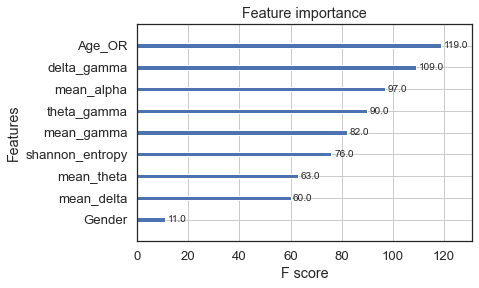

In [116]:
xgb.plot_importance(xgb_classifier)


## Logistic Regression and SVM

## SHAP Explanations

In [101]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.34)

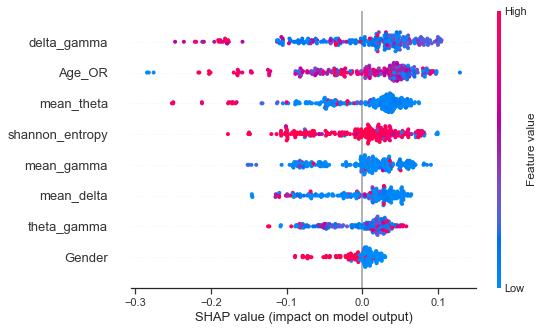

In [128]:
import shap
random_forest_clf.fit(X_train,Y_train)
f = plt.figure()
shap_values_rfc = shap.TreeExplainer(random_forest_clf).shap_values(X_train)
shap.summary_plot(shap_values_rfc[0],X_train,plot_type="dot")

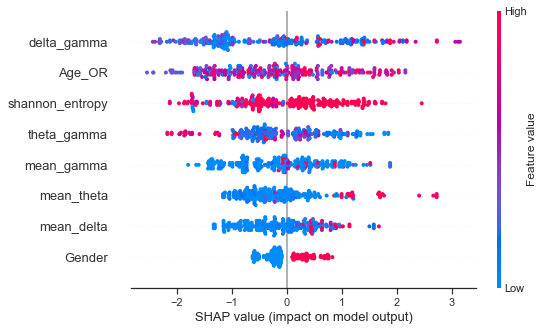

In [129]:
xgb_classifier.fit(X_train,Y_train)
f = plt.figure()
shap_values_xgb = shap.TreeExplainer(xgb_classifier).shap_values(X_train)
shap.summary_plot(shap_values_xgb,X_train)

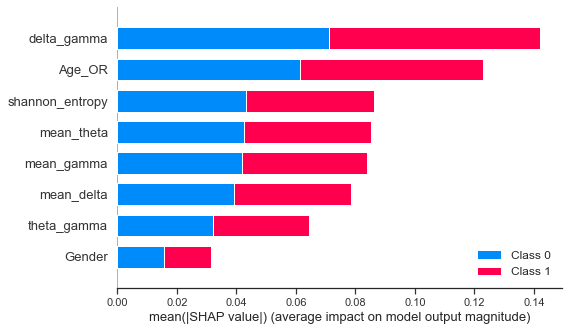

In [104]:
shap.summary_plot(shap_values_rfc,X_train,plot_type = "bar")

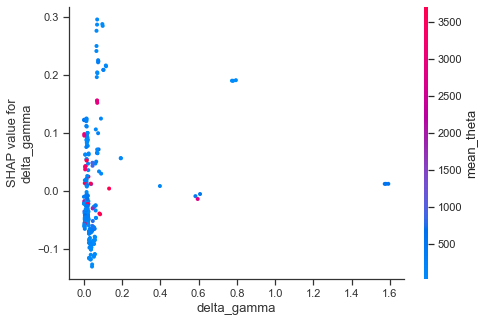

In [105]:
shap.dependence_plot("delta_gamma", shap_values_rfc[1], X_train)